# Weighted ECM clustering vs Traditional ECM clustering
### With IRIS (UCI dataset)

In [11]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from evclust.ecm import ecm
from evclust.wecm_new import wecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot, plotting, calculate_non_specificity
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt


   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2


D:\vtdo\projects\evclust\src\evclust\utils.py:1085: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


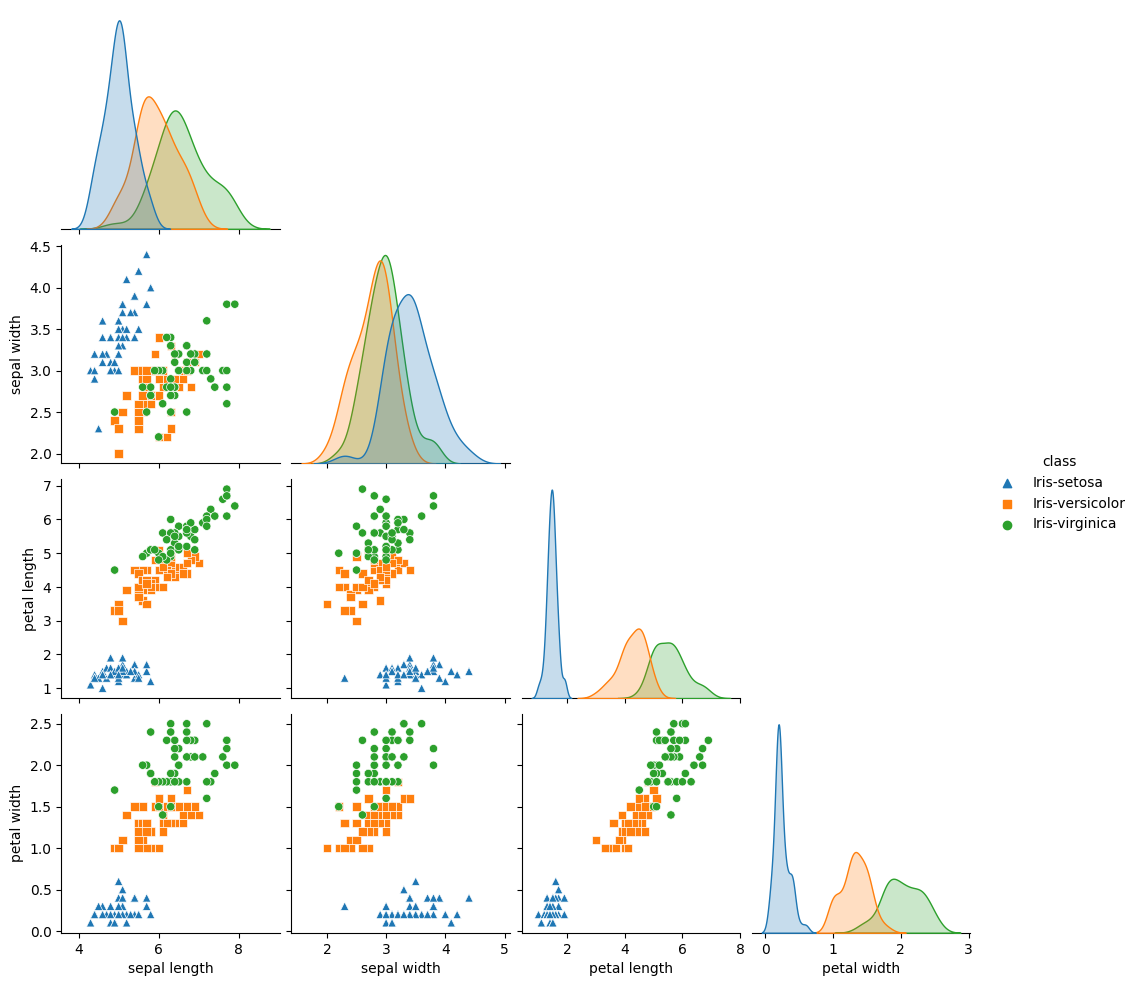

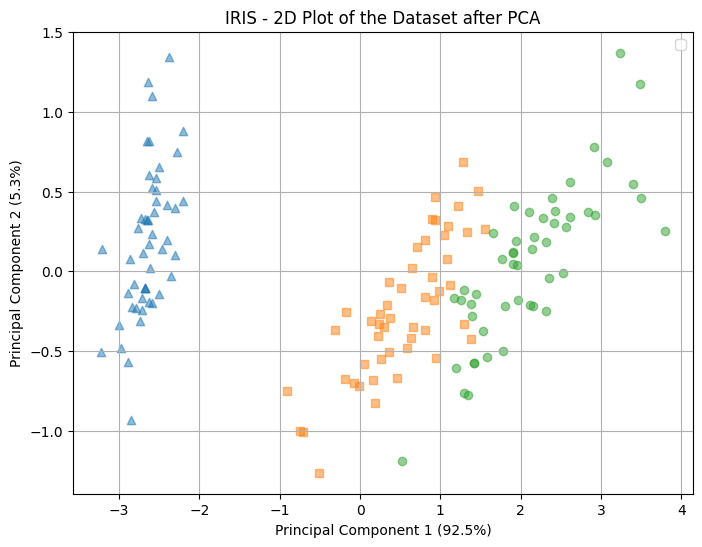

In [12]:
# fetch dataset - IRIS
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="IRIS", matrix_plot=True, markers=markers)

# Normalization
# scaler = MinMaxScaler((0,1))
# X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [13]:
%%capture
# Traditional ECM clustering
delta = np.sqrt(20)
model_list = np.array([])
for i in range(10):
    model = ecm(x=X, c=3, beta=2, alpha=1, delta=delta, ntrials=1, init="kmeans")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda x : x['crit'])
# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

J values: [37.56062613687252, 37.56062613687252, 37.56062613687252, 37.56062613687252, 37.56064484515289, 37.560674040610415, 37.560674040610415, 37.560674040610415, 37.560674040610415, 37.56067404061042]
ARI values: [0.6186778263658562, 0.6186778263658562, 0.6186778263658562, 0.6186778263658562, 0.6186778263658562, 0.6186778263658562, 0.6186778263658562, 0.6186778263658562, 0.6186778263658562, 0.6186778263658562]
NS values: [1.4214184110564254, 1.4099954578901222, 1.4214184110564254, 1.538474029449607, 1.4099347395930069, 1.4044209466043132, 1.421279271088719, 1.421279271088719, 1.4098325232179312, 1.4894342511752832]
NMI values: [0.6748634492283149, 0.6748634492283149, 0.6748634492283149, 0.6748634492283149, 0.6748634492283149, 0.6748634492283149, 0.6748634492283149, 0.6748634492283149, 0.6748634492283149, 0.6748634492283149]
Average ARI values: 0.6186778263658563
Average Non-specificity: 1.434748731222055
Average Normalized mutual infor: 0.674863449228315
Center: [[4.96305904 3.3453

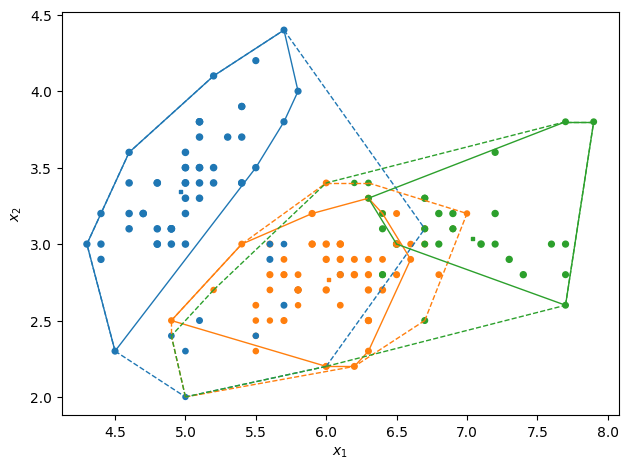

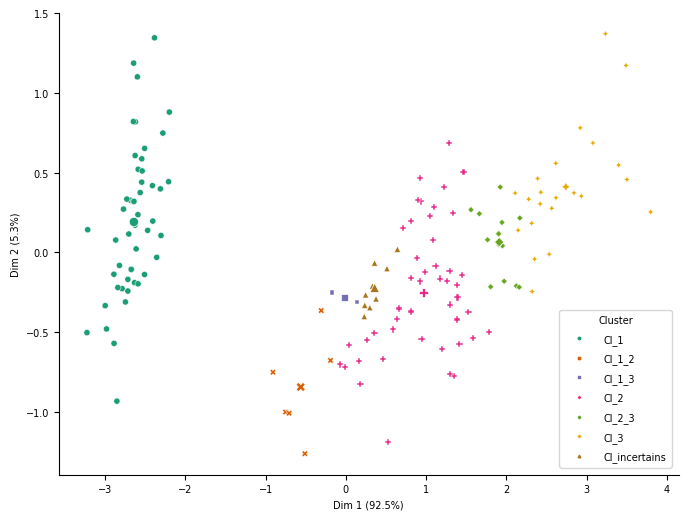

In [14]:

print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")
print(f"Center: {model_list[0]['g']}")
# Plotting the the model with the minimum J value
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)


## Weighted ECM (WECM)

In [15]:
# %%capture
# Weighted ECM clustering
model_list = np.array([])
c = 3
d = X.shape[1]
for i in range(10):
    W = np.ones((c, d)) * (1/d)
    # W = None
    g0 = None
    delta = np.sqrt(20)
    model = wecm(x=X, c=c, g0=g0, W=W, beta=2, alpha=1, delta=delta, epsi=1e-3, ntrials=1, init="kmeans", stopping_factor="center")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda model: model['crit'])

# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

Initial weights: 
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
---------Iteration #1---------
Initial prototypes: 
 [[6.85384615 3.07692308 5.71538462 2.05384615]
 [5.006      3.418      1.464      0.244     ]
 [5.88360656 2.74098361 4.38852459 1.43442623]]
[1, 1.7925575478421316]
[2, 1.480358595571621]
[3, 1.3527754971602648]
[4, 1.246938214196249]
[5, 1.167371159455635]
[6, 1.1253982273075696]
[7, 1.1093760968266646]
[8, 1.1042447371095403]
[9, 1.1025945620013777]
[10, 1.1019806190478785]
[11, 1.1017026510506929]
[12, 1.1015476668045896]
[13, 1.1014603685076128]
[14, 1.101412324555168]
[15, 1.1013783074710033]
[16, 1.101357947567283]
[17, 1.1013439727154368]
[18, 1.1013353840001248]
[19, 1.1013289749596424]
[20, 1.1013250676189124]
[21, 1.101322418392751]
[22, 1.1013203983370559]
---------End Iteration #1---------
Initial weights: 
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
---------Iteration #1---------
Initial prototypes: 
 [[5.

In [16]:

print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")


J values: [1.1013203983370559, 1.101320398337056, 1.1013204789670954, 1.1013204789670963, 1.1013204789670963, 1.1013204789670963, 1.1013204789670967, 1.101320478967097, 1.101320478967097, 1.1013204789670974]
ARI values: [0.4252066898583907, 0.4252066898583907, 0.4252066898583907, 0.4252066898583907, 0.4252066898583907, 0.4252066898583907, 0.4252066898583907, 0.4252066898583907, 0.4252066898583907, 0.4252066898583907]
NS values: [1.7072434362511444, 1.6794538163480504, 1.6059061297896327, 1.679108669271225, 1.679108669271225, 1.679108669271225, 1.7068614222773735, 1.7731958158191068, 1.7731958158191068, 1.6460977215684718]
NMI values: [0.4715459574116274, 0.4715459574116274, 0.4715459574116274, 0.4715459574116274, 0.4715459574116274, 0.4715459574116274, 0.4715459574116274, 0.4715459574116274, 0.4715459574116274, 0.4715459574116274]
Average ARI values: 0.4252066898583907
Average Non-specificity: 1.6929280165686564
Average Normalized mutual infor: 0.47154595741162736


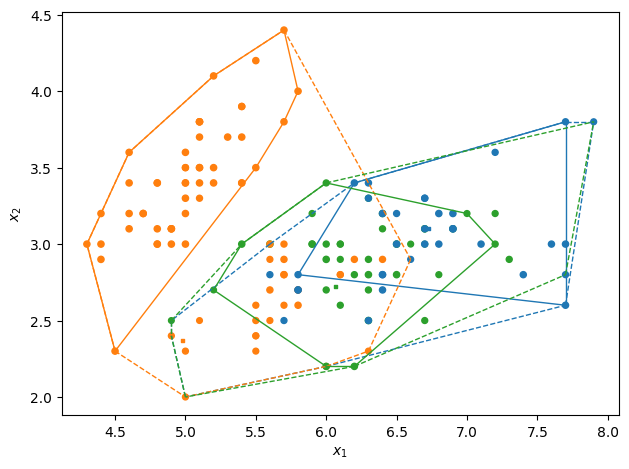

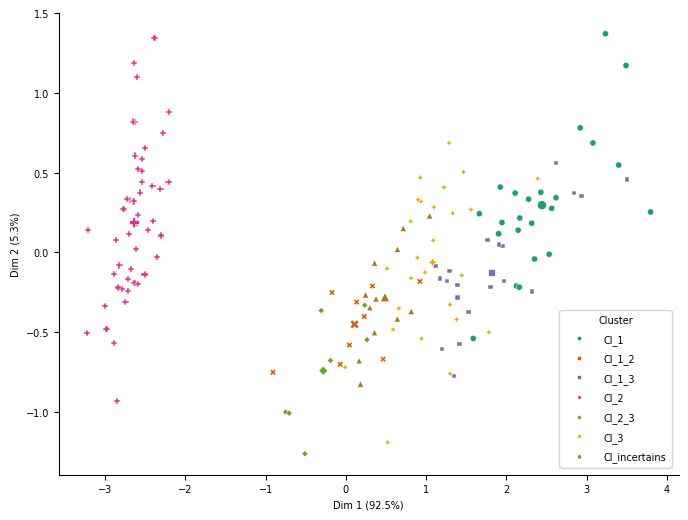

In [17]:
# Plotting PCA of the best model
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

In [18]:
top_weights = [model['W'] for model in model_list]
for W in top_weights:
    print(f"\n{W}")


[[0.04425571 0.20432165 0.02637027 0.72505238]
 [0.05688406 0.00614913 0.16617701 0.7707898 ]
 [0.01388781 0.05301866 0.00942285 0.92367069]]

[[0.01388781 0.05301866 0.00942285 0.92367069]
 [0.04425571 0.20432165 0.02637027 0.72505238]
 [0.05688406 0.00614913 0.16617701 0.7707898 ]]

[[0.05687032 0.00616458 0.16604354 0.77092156]
 [0.04426836 0.20422509 0.02638863 0.72511792]
 [0.01395441 0.05320851 0.00944126 0.92339581]]

[[0.01395441 0.05320851 0.00944126 0.92339581]
 [0.04426836 0.20422509 0.02638863 0.72511792]
 [0.05687032 0.00616458 0.16604354 0.77092156]]

[[0.01395441 0.05320851 0.00944126 0.92339581]
 [0.04426836 0.20422509 0.02638863 0.72511792]
 [0.05687032 0.00616458 0.16604354 0.77092156]]

[[0.01395441 0.05320851 0.00944126 0.92339581]
 [0.04426836 0.20422509 0.02638863 0.72511792]
 [0.05687032 0.00616458 0.16604354 0.77092156]]

[[0.04426836 0.20422509 0.02638863 0.72511792]
 [0.05687032 0.00616458 0.16604354 0.77092156]
 [0.01395441 0.05320851 0.00944126 0.92339581]]

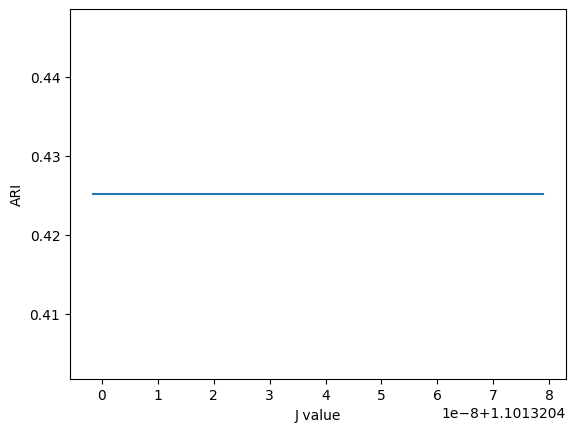

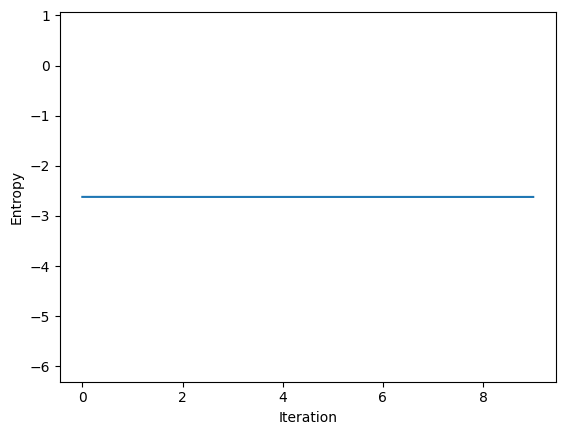

In [19]:
# J-ARI correlation chart
top_model_J = [model['crit'] for model in model_list]
plt.clf()
plt.plot(top_model_J, ari_list)
plt.xlabel("J value")
plt.ylabel("ARI")
plt.show()

entropy_list = [ np.sum( w * np.log2(w), axis=None) for w in top_weights]
print()
plt.clf()
plt.plot(entropy_list)
plt.xlabel("Iteration")
plt.ylabel("Entropy") 
plt.axis('equal')
plt.show()